In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import lmfit
from scipy.stats import linregress
import warnings
warnings.filterwarnings('ignore')

import data_container
from func import filters as fil
from func import Load, Fitting, Crop, Calc

### Loading Data and Viewing Raw Results

Text(0, 0.5, 'dP/dH (a.u.)')

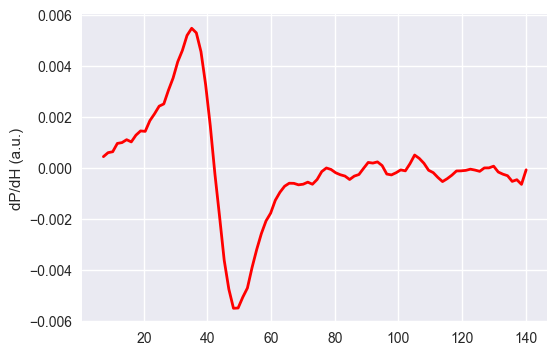

In [2]:
dir = r'C:\Users\plyslab\Desktop\VNA Automation\Data\2port\Shift dPdH\NiFe_test'

def numOfValues(dir):
    for count in range(10000):
        if os.path.join(dir, os.listdir(dir)[count]).endswith('csv'):
            totalValues = pd.read_csv(os.path.join(dir, os.listdir(dir)[count])).shape[0]
            return totalValues

# Add a dummy row
data = np.zeros(numOfValues(dir))
fields = np.zeros(numOfValues(dir))

for file in os.listdir(dir):
    path = os.path.join(dir, file)
    if path.endswith('.csv'):
        df = pd.read_csv(path)
        data = np.row_stack((data, df.loc[:,'dPdH Data']))
        fields = np.row_stack((fields, df.loc[:,'Fields']))

# Remove the dummy row
data = data[1:][:, 5:-4]
fields = fields[1:][:, 5:-4]

plt.figure(figsize=(6,4))
plt.plot(fields[0], data[0], 'r', linewidth=2)
plt.ylabel('dP/dH (a.u.)')

# Model Development

In [3]:
# FMR Spectrum Fit Equation
_dp_dh_script = '''
def dp_dh_fitfunct(h, %(prefix)sK1, %(prefix)sK2, %(prefix)sH_FMR, %(prefix)sDH):
    K1 = %(prefix)sK1
    K2 = %(prefix)sK2
    H_FMR = %(prefix)sH_FMR
    DH = %(prefix)sDH
    dh = h - H_FMR
    denom = (DH**2 + dh**2)**2
    return (-K1*2*dh*DH - K2*(DH**2-dh**2))/denom
'''

def dp_dh_model(prefix=''):
    expr = 'dp_dh_fitfunct(x, %(prefix)sK1, %(prefix)sK2, %(prefix)sH_FMR, %(prefix)sDH)' % {'prefix': prefix}
    script = _dp_dh_script % {'prefix': prefix}
    return lmfit.models.ExpressionModel(expr, independent_vars=['x'], init_script=script)

### SET FREQUENCY BOUNDS AND INTERVAL HERE

In [4]:
# Frequency range that you want to analyze
lower_freq = 2
upper_freq = 5
freq = np.linspace(lower_freq, upper_freq, data.shape[0])

In [5]:
Data = data_container.DataContainer()

data_shape = fields.shape
Data['f'] = freq
Data['field'] = np.zeros(data_shape, dtype=float)
Data['Raw'] = np.zeros(data_shape, dtype=float)
Data['Fitted'] = np.zeros(data_shape, dtype=float)

### This cell will fit our model on the original data set and show the respective plots.

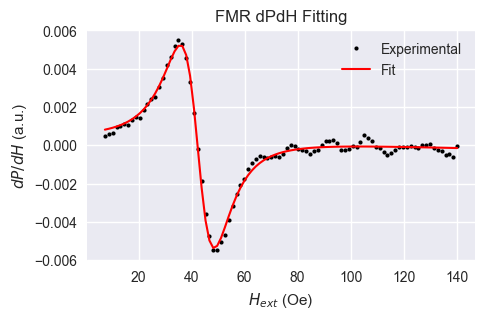

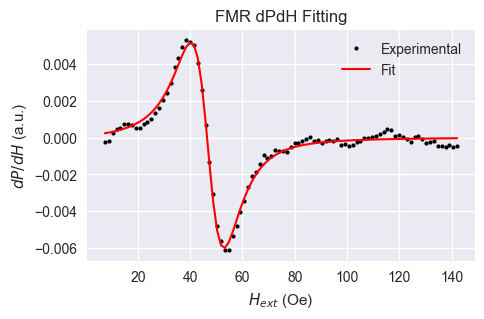

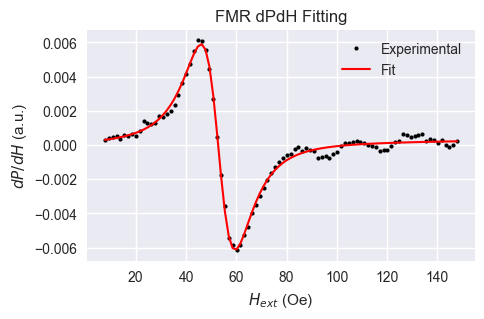

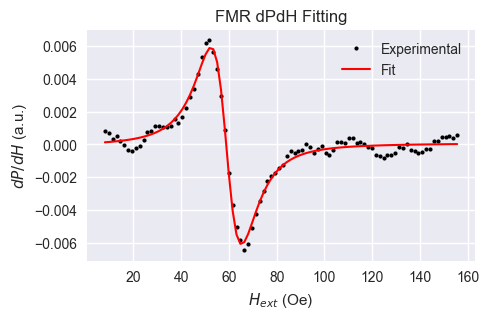

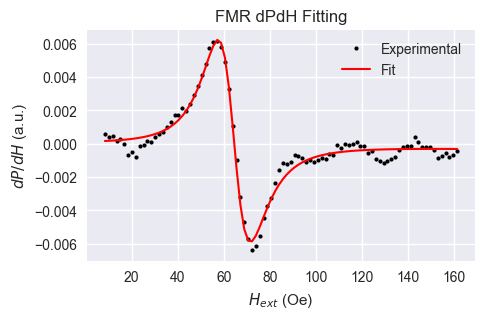

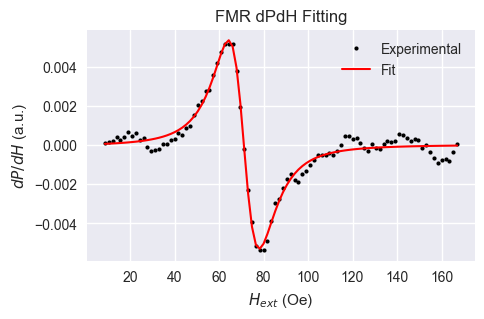

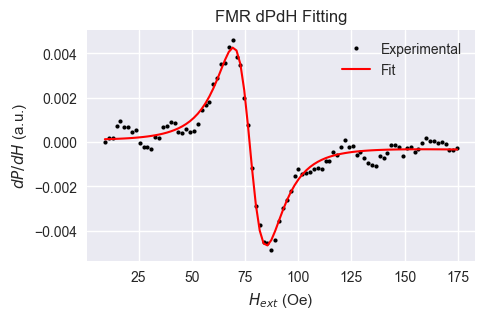

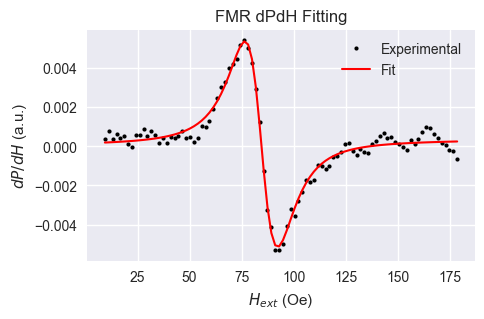

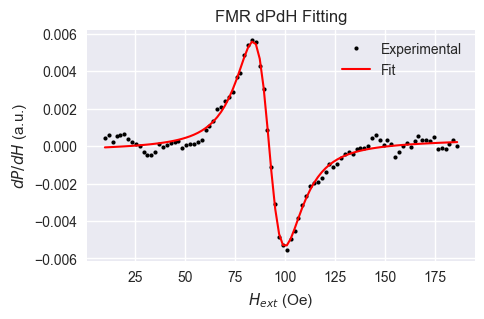

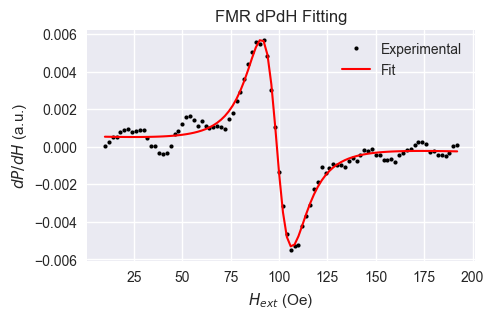

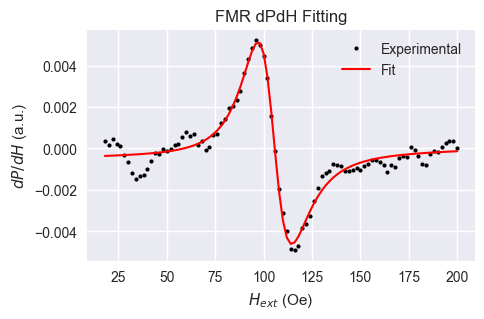

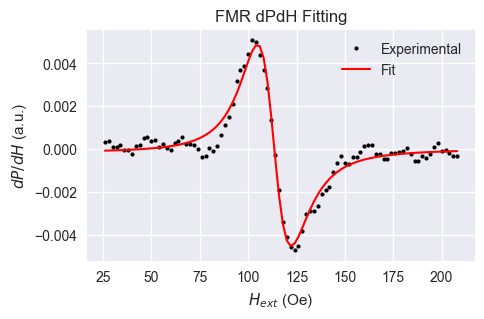

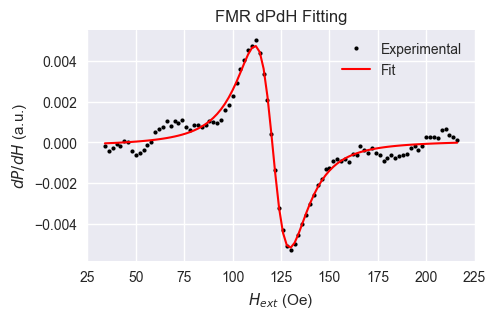

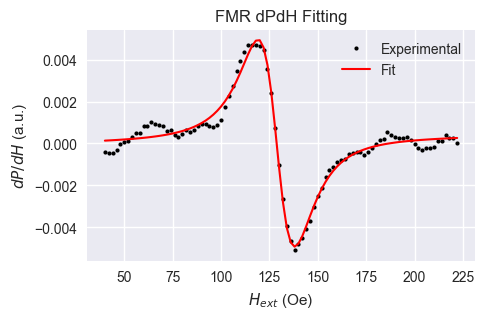

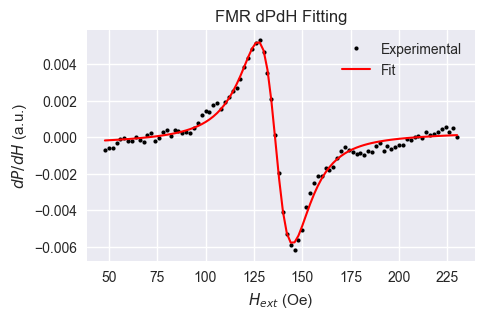

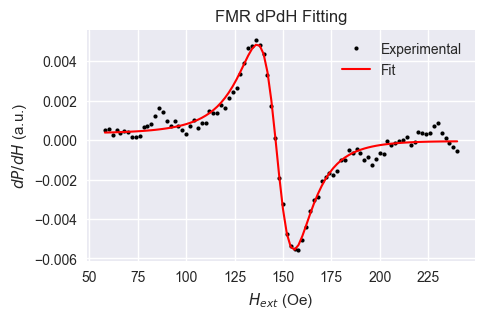

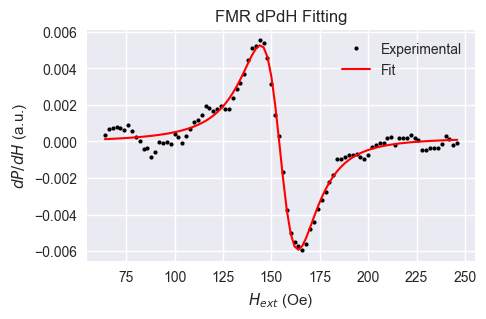

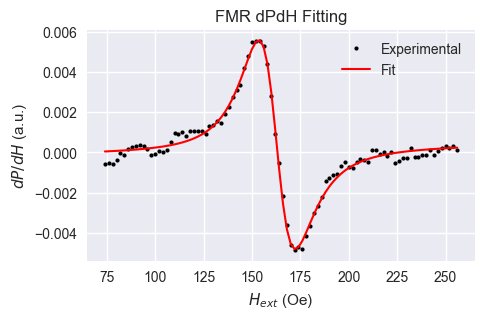

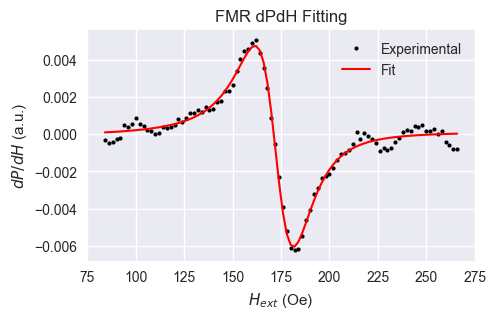

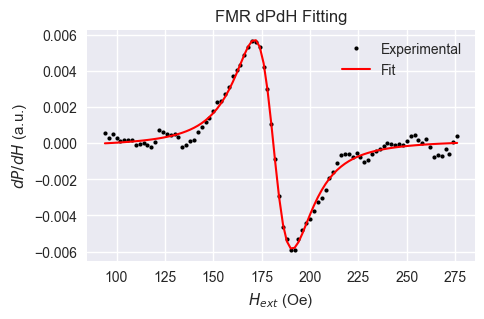

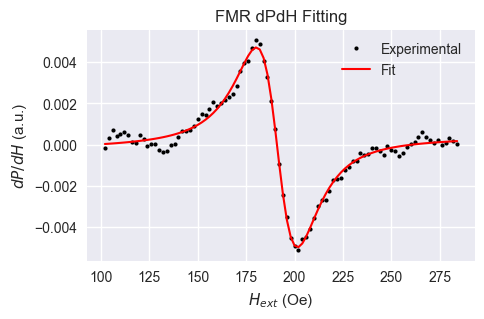

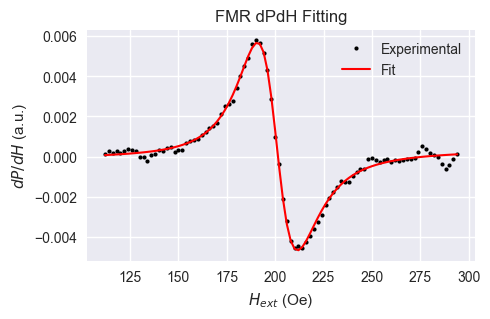

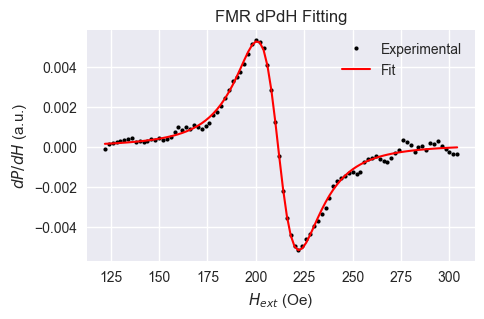

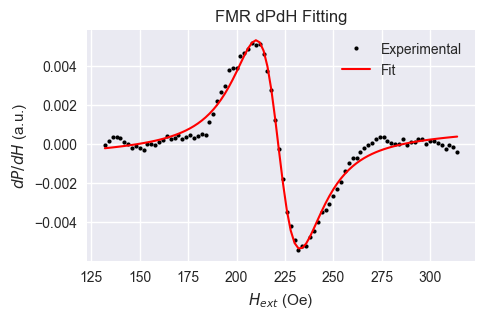

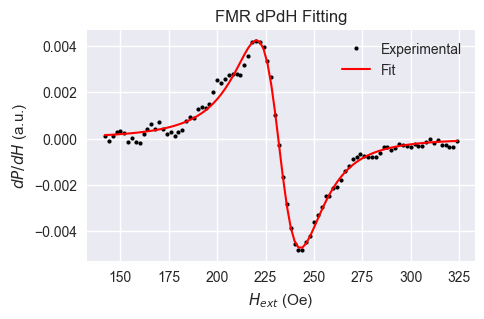

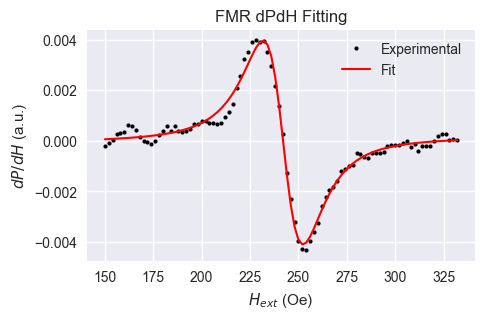

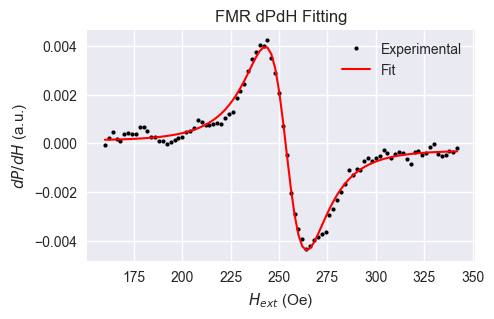

In [6]:
import numpy as np
import lmfit
import os
import pandas as pd
import matplotlib.pyplot as plt

# Create an empty DataFrame to store parameter values and uncertainties
parameter_values_df = pd.DataFrame(columns=['Frequency (GHz)', 'K1', 'K2', 'H_FMR', 'DH', 'Intercept', 'Slope'])

# Loop over frequencies
for num in range(len(freq)):
    field = fields[num]
    signal = data[num]
    dh = abs(field[signal.argmax()] - field[signal.argmin()])
    K1 = abs(signal.max() - signal.min()) / 2 * 36 / 25 * 5 * dh**2
    K2 = 0
    H_fmr = abs(field[signal.argmin()] + field[signal.argmax()]) / 2

    # Create the model
    peak = dp_dh_model('pA_')
    bg = lmfit.models.LinearModel(prefix='bg_')
    model = peak + bg

    # Set initial parameters
    pars = model.make_params()
    pars['pA_K1'].set(K1)
    pars['pA_K2'].set(K2)
    pars['pA_H_FMR'].set(H_fmr)
    pars['pA_DH'].set(dh)
    pars['bg_intercept'].set(0)
    pars['bg_slope'].set(0)

    # Fit the model to your data
    fit_result = model.fit(signal, params=pars, x=field)
    fit_data = np.zeros(len(field))

    fitX = field
    fitY = model.eval(fit_result.params, x=fitX)
    
    Data['field'][num] = fitX
    Data['Raw'][num] = signal
    Data['Fitted'][num] = fitY

    fit_data = np.row_stack((fit_data, fitY))

    # Plot your data and the fit
    plt.figure(figsize=(5, 3))
    plt.plot(field, signal, 'ko', label='Experimental', markersize=3)
    plt.plot(fitX, fitY, 'r-', label='Fit', linewidth=1.5)
    plt.xlabel('$H_{ext}$ (Oe)')
    plt.ylabel('$dP/dH$ (a.u.)')
    plt.title(f'FMR dPdH Fitting')
    plt.legend()
    plt.grid(True)
    
    # Append parameter values and uncertainties to the DataFrame
    new_data = {
        'Frequency (GHz)': freq[num],
        'K1': fit_result.params['pA_K1'].value,
        'K2': fit_result.params['pA_K2'].value,
        'H_FMR': fit_result.params['pA_H_FMR'].value,
        'DH': abs(fit_result.params['pA_DH'].value),
        'Intercept': fit_result.params['bg_intercept'].value,
        'Slope': fit_result.params['bg_slope'].value,
        'K1_Uncertainty': fit_result.params['pA_K1'].stderr,
        'K2_Uncertainty': fit_result.params['pA_K2'].stderr,
        'H_FMR_Uncertainty': fit_result.params['pA_H_FMR'].stderr,
        'DH_Uncertainty': fit_result.params['pA_DH'].stderr,
        'Intercept_Uncertainty': fit_result.params['bg_intercept'].stderr,
        'Slope_Uncertainty': fit_result.params['bg_slope'].stderr,
    }

    parameter_values_df = pd.concat([parameter_values_df, pd.DataFrame([new_data])], ignore_index=True)
    
    ################## CHANGE DIRECTORY HERE #####################

    output_directory = r"C:\Users\plyslab\Desktop\VNA Automation\Data\2port\Fitted data\NiFe_test"
    
    plot_filename = os.path.join(output_directory, f'Fitted_plot_%.2f_GHz.png' %freq[num])
    plt.savefig(plot_filename)

# Save the updated DataFrame to the existing CSV file
filename = r"\NiFe_parameter_values.csv"
csv_file_path = output_directory + filename
parameter_values_df.to_csv(csv_file_path, index=False)

fit_filename = r'\NiFe_Fit_values.npz'
fit_file_path = output_directory + fit_filename
Data.save(fit_file_path)

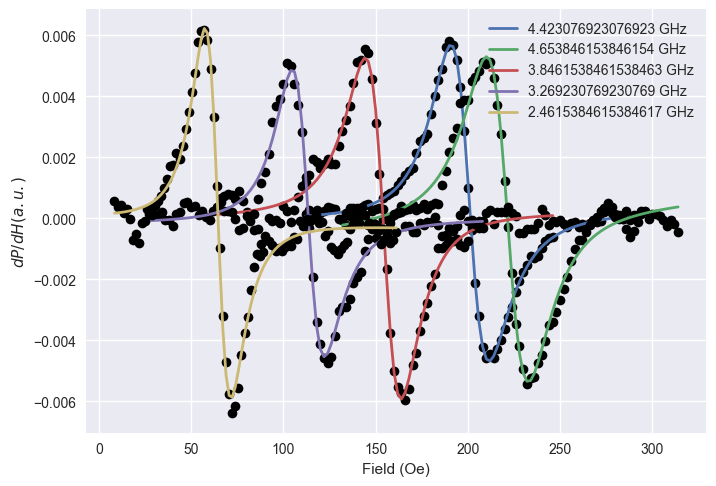

In [10]:
frequency, field, raw_data, fit_data = Load.NPZ_Fit(fit_file_path)

import random
for i in random.sample(list(freq), 5):
    Fitting.fit_plot(freq=i, frequency=frequency, field=field, raw_data=raw_data, fitted_data=fit_data)

# Kittel Fitting

In [11]:
fileName = r'c:\Users\plyslab\Desktop\VNA Automation\Data\Spin_pumping\1_Port_MgO5NiFe20Mgo15_0o_0.3-15.0_GHz_@_-1000.0-1000.0_Oe'
Info, freq, field, RefS11, S11 = Load.NPZ_1P(fileName)

In [12]:
lower_freq = 0.5
upper_freq = 5
lower_field = 0
upper_field = 500

In [13]:
freq_used = Crop.cut_freq(freq, lower_freq, upper_freq)[0]
lower_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[1]
upper_freq = Crop.cut_freq(freq, lower_freq, upper_freq)[2]

field_used = Crop.cut_field(field, lower_field, upper_field)[0]
lower_field = Crop.cut_freq(field, lower_field, upper_field)[1]
upper_field = Crop.cut_freq(field, lower_field, upper_field)[2]

abspow = Calc.AbsPower1P(S11, RefS11)
    
filteredData = fil.Filter_Spline(abspow, a=0.1)
filteredData = fil.FilterBG_Median(filteredData)
filteredData = fil.FilterBG_MedianH(filteredData)

cutData = filteredData[lower_freq:upper_freq, lower_field:upper_field]

Gyromagnetic Ratio (γ): 1.76e-02 Hz/Oe
Saturation Magnetization (Ms): 750 emu/cm^3
Effective Magnetization (Meff): -1213.4954084936207 emu/cm^3
Uniaxial Anistropy (ku): 0.52 erg/cm^2


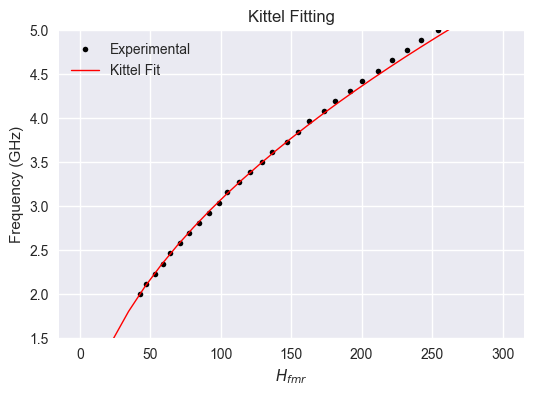

In [32]:
from numpy import pi, sqrt
############ ADJUST DIRECTORY HERE ############
parameter_path = r"c:\Users\plyslab\Desktop\VNA Automation\Data\2port\Fitted data\NiFe_test\NiFe_parameter_values.csv"

fit_data = pd.read_csv(parameter_path)
freq = frequency
H_FMR = fit_data.loc[:, 'H_FMR']
line_width = fit_data.loc[:, 'DH']

#Uncertainties in parameters
H_FMR_stderr = fit_data.loc[:, 'H_FMR_Uncertainty']
line_width_stderr = fit_data.loc[:, 'DH_Uncertainty']

H = np.linspace(0, 300, len(H_FMR))
gamma = 17.60E6/1E9      #17.60E6/1E9 NiFe
Ms = 750
ku = 0.52
T = 20 *1E7
Hu = 2500
Meff = Ms - (Hu/4*pi)
Hk = 0
Hr = 0

# Kittel Equation
def kittel_equation():
    return gamma/(2*pi) * sqrt((4*pi*Ms + Hu + H + Hk + Hr) * (H + Hk + Hr))

kittel_results = kittel_equation()

# Plotting
plt.figure(figsize=(6, 4))

## Make sure that the sample under test is the same for both the color plot and kittel fit. If it is, uncomment the line below.
# plt.pcolormesh(field_used, freq_used, cutData, cmap='coolwarm')
# plt.colorbar()

plt.plot(H_FMR, freq, 'ko', markersize=4, label='Experimental')
plt.plot(H, kittel_results, 'r-', linewidth=1, label='Kittel Fit')
plt.xlabel('$H_{fmr}$')
plt.ylabel('Frequency (GHz)')
plt.legend()
plt.title('Kittel Fitting')
plt.ylim(1.5, 5)
# plt.xlim(0, 400)


print(f'Gyromagnetic Ratio (γ): {gamma:.2e} Hz/Oe')
print(f'Saturation Magnetization (Ms): {Ms} emu/cm^3')
print(f'Effective Magnetization (Meff): {Meff} emu/cm^3')
print(f'Uniaxial Anistropy (ku): {ku} erg/cm^2')

# Linear Fitting

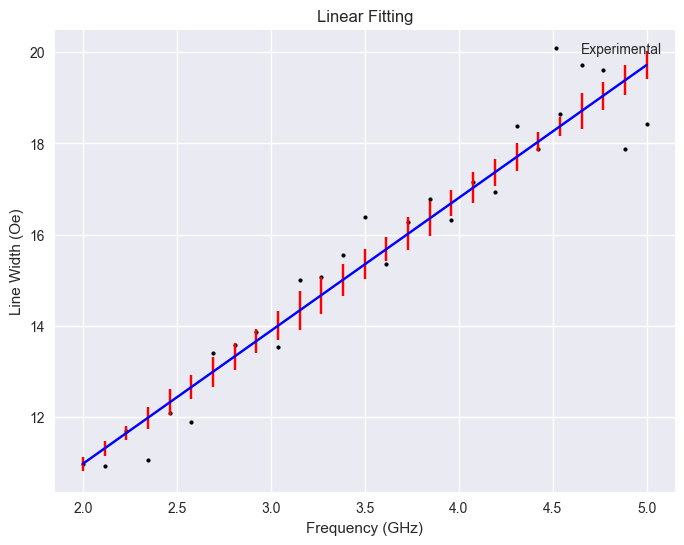

Results:

Slope: 2.9110
Intercept: 5.1603
R-squared: 0.9458
Standard Error: 0.1393
alpha:  8.2e-03


In [33]:
freq = frequency

# Linear Regression
slope, intercept, r_value, p_value, std_err = linregress(freq, line_width)

# Creating a linear fit line using the slope and intercept
fit_line = slope * freq + intercept

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(freq, line_width, 'ko', markersize=3, label='Experimental')
plt.errorbar(freq, fit_line, line_width_stderr, color='blue', ecolor='red')
plt.title('Linear Fitting')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Line Width (Oe)')
plt.legend()
plt.grid(True)
plt.show()

# Linear Regression Results
print('Results:\n')
print(f'Slope: {slope:.4f}')
print(f'Intercept: {intercept:.4f}')
print(f'R-squared: {r_value**2:.4f}')
print(f'Standard Error: {std_err:.4f}')

alpha = (gamma*slope)/(2*np.pi)
print(f'alpha: {alpha: .1e}')